### Coin-flipping example

Suppose, naively, that you are unsure about the probability of heads in a coin flip (spoiler alert: it's 50 \%). You believe there is some true underlying ratio, call it $p$, but have no prior opinion on what $p$ might be.

We begin to flip a coin, and record the observations: either $H$ or $T$. This is our observed data. An interesting question to ask is how our inference changes as we observe more and more data? More specifically, what do our posterior probabilities look like when we have little data, versus when we have lots of data.

Below we plot a sequence of updating posterior probabilities as we observe increasing amounts of data (coin flips).

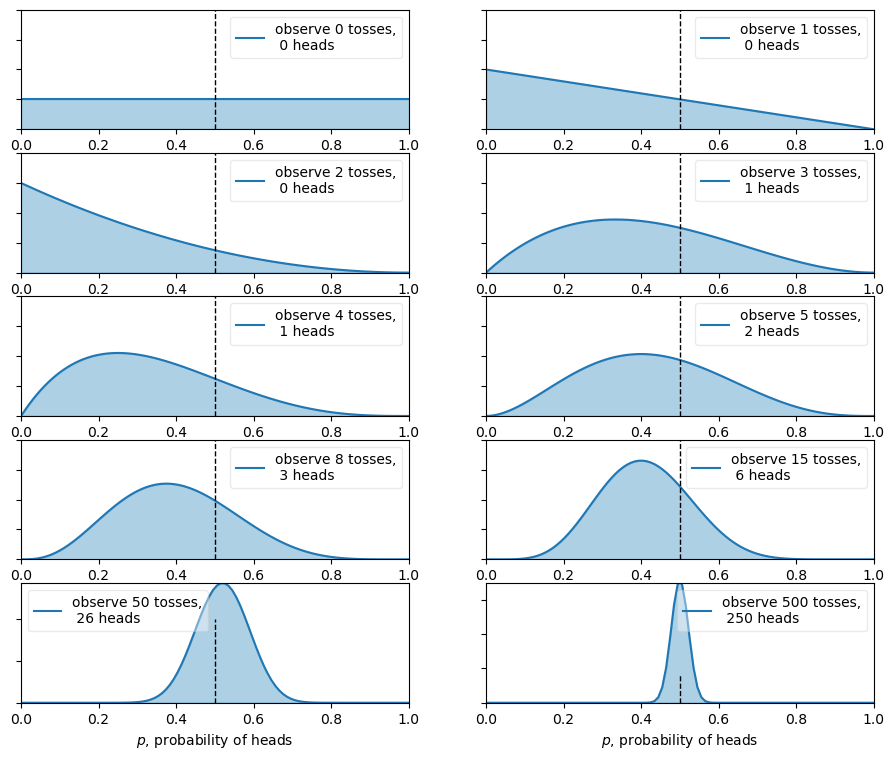

In [9]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

import scipy.stats as stats

dist = stats.beta
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
data = stats.bernoulli.rvs(0.5, size=n_trials[-1])
x = np.linspace(0, 1, 100)

# # For the already prepared, I'm using Binomial's conj. prior.
for k, N in enumerate(n_trials):
    sx = plt.subplot(int(len(n_trials) / 2), 2, k + 1)
    plt.xlabel("$p$, probability of heads") 
    #if k in [0, len(n_trials) - 1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    heads = data[:N].sum()
    y = dist.pdf(x, 1 + heads, 1 + N - heads) #by varuing parameters of the beta distribution we can see how prior influences posterior
    plt.plot(x, y, label="observe %d tosses,\n %d heads" % (N, heads))
    plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)

    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)

### Transferring into SBI framework

Clearly, this was a very simple example of Bayesian inference, where the posterior distribution was explicitly derived and hence there is no real need to use neither the sampling methods nor simulation based inference. Nevertheless, for the sake of understanding, how it can be transferred into the simulation based learning framework, we will repeat our inference (or at least a part of it) using the sbi package

For that we create a simulatior with one distribution parameter which simulates Bernoulli trials. We pre-define the number of trials $N=50$ and specify a uniform prior on the $(0,1)$ interval.

In [10]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

N=50
def simulator(p):    
    return torch.tensor(stats.bernoulli.rvs(p, size=N))
    
prior=utils.BoxUniform(low=torch.tensor([0.01]),high=torch.tensor([0.99]))    


Now we need to generate simulations given our prior, simulator and infer the approximate posterior distribution. We will use here the simplest method of inference SNPE, which infers the whole posterior distribution given the samples from the simulator by means of a normalizing flow, and does not require any further sampling algorithm afterwards.

In [18]:
posterior = infer(simulator, prior, method="SNPE", num_simulations=10000)

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations.: 100%|██████████| 10000/10000 [00:01<00:00, 8263.08it/s]
/p/project/training2405/sc_venv_sbi_local/venv/lib/python3.11/site-packages/sbi/neural_nets/flow.py:165: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel, y_numel = get_numel(batch_x, batch_y, embedding_net)


 Neural network successfully converged after 103 epochs.

Now let us pass an observation to our model with the idea of inferring the distribution parameter $p$. We use the same data as previously, when running the classical Bayesian inference. Note, that if we want to change $N$, the posterior inference has to be  run all over again.

We then draw samples from the posterior in order t be able to plot the distribution of the parameter $p$

One can easily change the inference method SNPE to SNRE or SNLE and see, how this saffects the results and their confidences. Also note, that since for SNLE and SNRE an actual MCMC algorithm has to be run, it takes longer time to sample froma posterior in thjose case.


In [19]:
observation=data[:N]
samples = posterior.sample((10000,), x=observation)


Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 17851.34it/s]


We now plot the resulting distribution together with the true value of the parameter (which is obviously 0.5). We can immediately see that the overall shape and skewness of the distribution with respect to the true value of the parameter is similar to the one we obtained before using classical inference. However, obviously, the spread of the distrbution is wider in the SBI case.

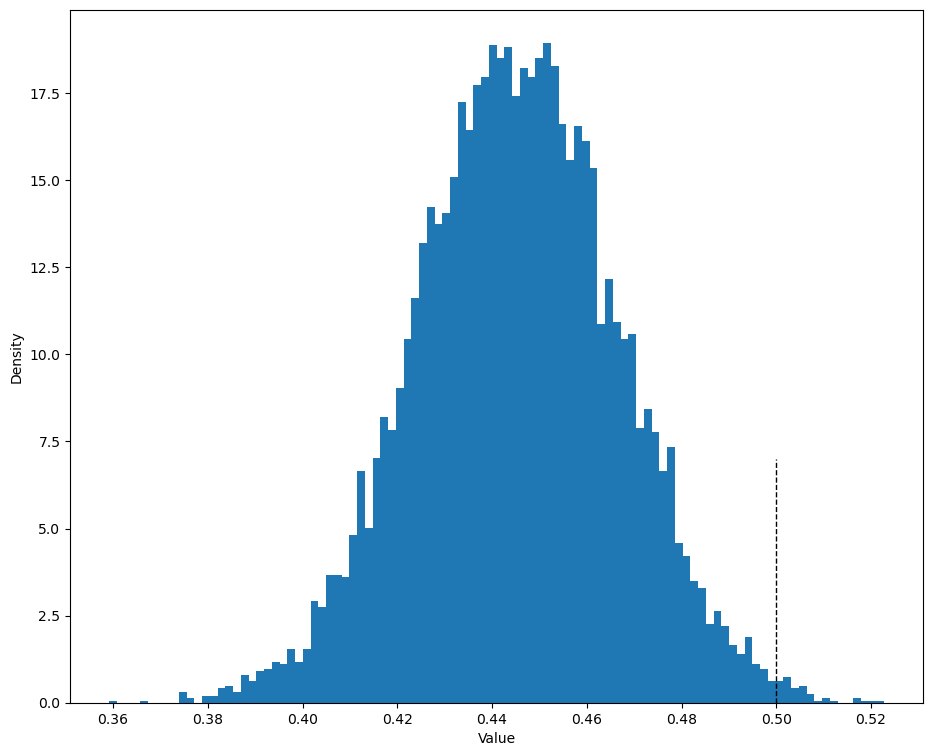

In [20]:
plt.hist(samples.numpy(), bins=100, density=True)
plt.vlines(0.5, 0, 7, color="k", linestyles="--", lw=1)
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()